In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Paths
asd_folder = '/content/drive/MyDrive/Autism Dataset/ASD'
control_folder = '/content/drive/MyDrive/Autism Dataset/Control'
image_folder = '/content/drive/MyDrive/Autism Dataset/Image'

def load_data(image_folder, gaze_folder, label, target_size=(224, 224)):
    X_images, X_gaze, y = [], [], []

    for filename in os.listdir(gaze_folder):
        img_path = os.path.join(image_folder, filename)
        gaze_path = os.path.join(gaze_folder, filename)

        # Load image and gaze map
        image = cv2.imread(img_path)
        gaze_map = cv2.imread(gaze_path, cv2.IMREAD_GRAYSCALE)  # Grayscale gaze map

        if image is not None and gaze_map is not None:
            # Resize both image and gaze map to the target size
            image_resized = cv2.resize(image, target_size)
            gaze_map_resized = cv2.resize(gaze_map, target_size)

            X_images.append(image_resized)
            X_gaze.append(gaze_map_resized)
            y.append(label)

    return np.array(X_images), np.array(X_gaze), np.array(y)

# Load ASD data
X_asd_images, X_asd_gaze, y_asd = load_data(image_folder, asd_folder, label=1)

# Load Control data
X_control_images, X_control_gaze, y_control = load_data(image_folder, control_folder, label=0)

# Combine data
X_images = np.concatenate((X_asd_images, X_control_images), axis=0)
X_gaze = np.concatenate((X_asd_gaze, X_control_gaze), axis=0)
y = np.concatenate((y_asd, y_control), axis=0)

# Normalize the images and gaze maps
X_images = X_images / 255.0
X_gaze = X_gaze / 255.0
y = to_categorical(y, num_classes=2)

In [ ]:
# Import necessary modules from Keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

# Define image size constants
image_height, image_width = 224, 224  # Resizing to 224x224

# Image input branch
image_input = Input(shape=(image_height, image_width, 3))  # RGB images
x_image = Conv2D(32, (3, 3), activation='relu')(image_input)
x_image = MaxPooling2D((2, 2))(x_image)
x_image = Conv2D(64, (3, 3), activation='relu')(x_image)
x_image = MaxPooling2D((2, 2))(x_image)
x_image = Flatten()(x_image)

# Gaze map input branch
gaze_input = Input(shape=(image_height, image_width, 1))  # Grayscale gaze maps
x_gaze = Conv2D(32, (3, 3), activation='relu')(gaze_input)
x_gaze = MaxPooling2D((2, 2))(x_gaze)
x_gaze = Conv2D(64, (3, 3), activation='relu')(x_gaze)
x_gaze = MaxPooling2D((2, 2))(x_gaze)
x_gaze = Flatten()(x_gaze)

# Combine the two branches
combined = Concatenate()([x_image, x_gaze])

# Dense layers for classification
x = Dense(128, activation='relu')(combined)
output = Dense(2, activation='softmax')(x)

# Define the model
model = Model(inputs=[image_input, gaze_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 91s 6s/step - accuracy: 0.4933 - loss: 6.9556 - val_accuracy: 0.9916 - val_loss: 0.4528
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.5547 - loss: 0.6694 - val_accuracy: 0.0084 - val_loss: 1.1076
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 85s 6s/step - accuracy: 0.6875 - loss: 0.5602 - val_accuracy: 0.3782 - val_loss: 0.9707
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 86s 6s/step - accuracy: 0.6917 - loss: 0.5616 - val_accuracy: 0.3193 - val_loss: 1.1720
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.7173 - loss: 0.5331 - val_accuracy: 0.3361 - val_loss: 1.1390
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.7370 - loss: 0.5137 - val_accuracy: 0.4790 - val_loss: 1.0783
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.7748 - loss: 0.4673 - val_accuracy: 0.0756 - val_loss: 1.9108
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.8112 - loss: 0.4605 - val_accuracy: 0.6134 - val_

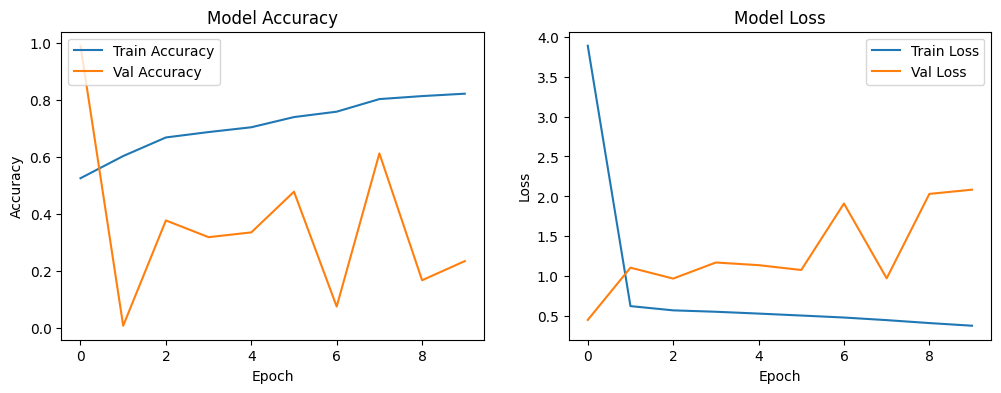

In [ ]:
import matplotlib.pyplot as plt

# Train the model and save the training history
history = model.fit([X_images, X_gaze], y, epochs=10, batch_size=32, validation_split=0.2)

# Plot accuracy and loss graphs
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.show()

# Call the plotting function
plot_training_history(history)

In [ ]:
import cv2
import numpy as np

# Set the image size to match your model
image_height, image_width = 224, 224

# Define file paths (assuming images are already uploaded to '/content')
input_image_path = '/content/11 (1).png'  # Replace with your test image file
input_gaze_map_path = '/content/11.png'  # Replace with the corresponding gaze map file

# Load the uploaded image and gaze map
input_image = cv2.imread(input_image_path)  # RGB image
input_gaze_map = cv2.imread(input_gaze_map_path, cv2.IMREAD_GRAYSCALE)  # Grayscale gaze map

# Resize the image and gaze map to match the training input size (224x224 in this case)
input_image_resized = cv2.resize(input_image, (image_height, image_width)) / 255.0  # Normalize the image
input_gaze_map_resized = cv2.resize(input_gaze_map, (image_height, image_width)) / 255.0  # Normalize gaze map

# Expand dimensions to match the input shape of the model
input_image_resized = np.expand_dims(input_image_resized, axis=0)  # Add batch dimension
input_gaze_map_resized = np.expand_dims(input_gaze_map_resized, axis=0)  # Add batch dimension
input_gaze_map_resized = np.expand_dims(input_gaze_map_resized, axis=-1)  # Add channel dimension for grayscale

# Model prediction
prediction = model.predict([input_image_resized, input_gaze_map_resized])

# Get the predicted class (ASD or Typical) and confidence
predicted_class = np.argmax(prediction, axis=1)[0]  # 0 for Typical, 1 for ASD
confidence = prediction[0][predicted_class] * 100  # Convert to percentage

# Output the results
if predicted_class == 1:
    print(f"Prediction: ASD with {confidence:.2f}% confidence.")
else:
    print(f"Prediction: Typical with {confidence:.2f}% confidence.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Prediction: Typical with 75.79% confidence.


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 272s 18s/step - accuracy: 0.5492 - loss: 2.3944 - val_accuracy: 0.0000e+00 - val_loss: 0.7318
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 310s 17s/step - accuracy: 0.6462 - loss: 0.6496 - val_accuracy: 0.0336 - val_loss: 0.7789
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 268s 17s/step - accuracy: 0.6829 - loss: 0.6087 - val_accuracy: 0.5882 - val_loss: 0.8178
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 255s 17s/step - accuracy: 0.6801 - loss: 0.5663 - val_accuracy: 0.1008 - val_loss: 1.4805
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 253s 17s/step - accuracy: 0.6890 - loss: 0.5856 - val_accuracy: 0.5714 - val_loss: 0.8765
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 251s 17s/step - accuracy: 0.7000 - loss: 0.5359 - val_accuracy: 0.6471 - val_loss: 0.7725
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 263s 17s/step - accuracy: 0.7203 - loss: 0.5082 - val_accuracy: 0.7227 - val_loss: 0.6909
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 261s 17s/step - accuracy: 0.7488 - loss: 0.5090 - val_accuracy

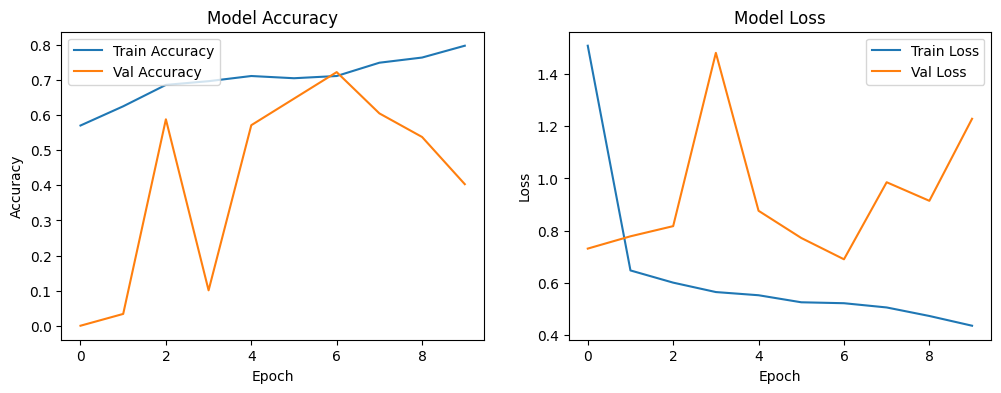

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# U-Net Encoder (Downsampling)
def unet_encoder(input_layer, filters):
    conv = Conv2D(filters, (3, 3), activation='relu', padding='same')(input_layer)
    conv = Conv2D(filters, (3, 3), activation='relu', padding='same')(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

# U-Net Decoder (Upsampling)
def unet_decoder(input_layer, skip_connection, filters):
    up = UpSampling2D(size=(2, 2))(input_layer)
    up = Conv2D(filters, (3, 3), activation='relu', padding='same')(up)
    concat = Concatenate()([up, skip_connection])
    conv = Conv2D(filters, (3, 3), activation='relu', padding='same')(concat)
    conv = Conv2D(filters, (3, 3), activation='relu', padding='same')(conv)
    return conv

# Build U-Net for classification
def build_unet_model(input_shape):
    # Image input
    image_input = Input(shape=input_shape)  # RGB image input
    # Gaze map input
    gaze_input = Input(shape=(input_shape[0], input_shape[1], 1))  # Grayscale gaze map input

    # Encoder (Image)
    conv1_image, pool1_image = unet_encoder(image_input, 32)
    conv2_image, pool2_image = unet_encoder(pool1_image, 64)

    # Encoder (Gaze)
    conv1_gaze, pool1_gaze = unet_encoder(gaze_input, 32)
    conv2_gaze, pool2_gaze = unet_encoder(pool1_gaze, 64)

    # Flatten the output
    flat_image = Flatten()(pool2_image)
    flat_gaze = Flatten()(pool2_gaze)

    # Combine both branches
    combined = Concatenate()([flat_image, flat_gaze])

    # Dense layers for classification
    x = Dense(128, activation='relu')(combined)
    output = Dense(2, activation='softmax')(x)  # 2 classes: ASD or Typical

    # Define the model
    model = Model(inputs=[image_input, gaze_input], outputs=output)

    return model

# Input shapes
image_height, image_width = 224, 224
input_shape = (image_height, image_width, 3)  # For the image

# Build U-Net model
model = build_unet_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X_images, X_gaze], y, epochs=10, batch_size=32, validation_split=0.2)

# Plot accuracy and loss graphs
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.show()

# Call the plotting function
plot_training_history(history)

In [ ]:
import cv2
import numpy as np

# Set the image size to match your model
image_height, image_width = 224, 224

# Define file paths (assuming images are already uploaded to '/content')
input_image_path = '/content/6 (1).png'  # Replace with your test image file
input_gaze_map_path = '/content/6.png'  # Replace with the corresponding gaze map file

# Load the uploaded image and gaze map
input_image = cv2.imread(input_image_path)  # RGB image
input_gaze_map = cv2.imread(input_gaze_map_path, cv2.IMREAD_GRAYSCALE)  # Grayscale gaze map

# Resize the image and gaze map to match the training input size (224x224 in this case)
input_image_resized = cv2.resize(input_image, (image_height, image_width)) / 255.0  # Normalize the image
input_gaze_map_resized = cv2.resize(input_gaze_map, (image_height, image_width)) / 255.0  # Normalize gaze map

# Expand dimensions to match the input shape of the model
input_image_resized = np.expand_dims(input_image_resized, axis=0)  # Add batch dimension
input_gaze_map_resized = np.expand_dims(input_gaze_map_resized, axis=0)  # Add batch dimension
input_gaze_map_resized = np.expand_dims(input_gaze_map_resized, axis=-1)  # Add channel dimension for grayscale

# Model prediction
prediction = model.predict([input_image_resized, input_gaze_map_resized])

# Get the predicted class (ASD or Typical) and confidence
predicted_class = np.argmax(prediction, axis=1)[0]  # 0 for Typical, 1 for ASD
confidence = prediction[0][predicted_class] * 100  # Convert to percentage

# Output the results
if predicted_class == 1:
    print(f"Prediction: ASD with {confidence:.2f}% confidence.")
else:
    print(f"Prediction: Typical with {confidence:.2f}% confidence.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
Prediction: Typical with 64.86% confidence.


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 125s 8s/step - accuracy: 0.5693 - loss: 25.1264 - val_accuracy: 0.0000e+00 - val_loss: 0.6977
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 146s 8s/step - accuracy: 0.6270 - loss: 0.6869 - val_accuracy: 0.0000e+00 - val_loss: 0.7056
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 139s 8s/step - accuracy: 0.6572 - loss: 0.6889 - val_accuracy: 0.0000e+00 - val_loss: 0.7123
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - accuracy: 0.6086 - loss: 0.6889 - val_accuracy: 0.0000e+00 - val_loss: 0.7179
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.6109 - loss: 0.6876 - val_accuracy: 0.0000e+00 - val_loss: 0.7249
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 147s 8s/step - accuracy: 0.6424 - loss: 0.6843 - val_accuracy: 0.0000e+00 - val_loss: 0.7322
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 117s 8s/step - accuracy: 0.6231 - loss: 0.6842 - val_accuracy: 0.0000e+00 - val_loss: 0.7388
Epoch 8/10
15/15 ━━━━━━━━━━━━━━

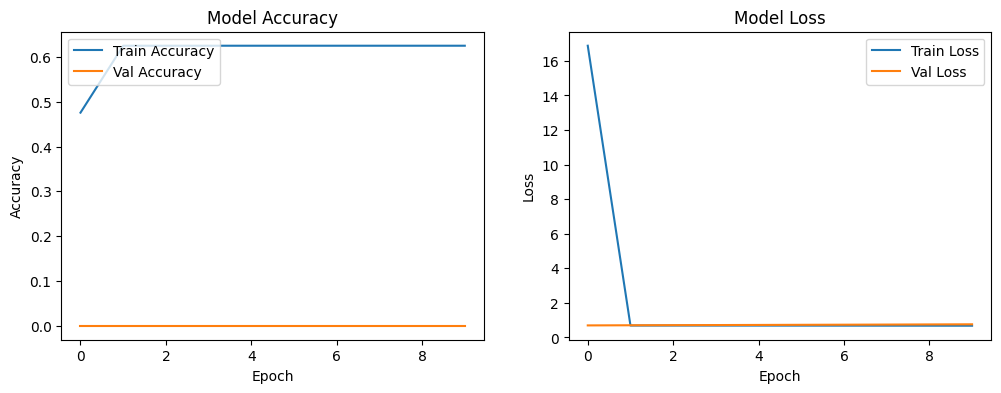

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
import matplotlib.pyplot as plt

# Build InceptionV3-based model for classification
def build_inceptionv3_model(input_shape):
    # Image input (InceptionV3 will handle this input)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the pre-trained layers

    # Gaze map input
    gaze_input = Input(shape=(input_shape[0], input_shape[1], 1))  # Grayscale gaze map input

    # Image branch (using InceptionV3)
    x_image = base_model.output
    x_image = Flatten()(x_image)

    # Gaze map branch (basic CNN)
    x_gaze = Conv2D(32, (3, 3), activation='relu', padding='same')(gaze_input)
    x_gaze = MaxPooling2D(pool_size=(2, 2))(x_gaze)
    x_gaze = Conv2D(64, (3, 3), activation='relu', padding='same')(x_gaze)
    x_gaze = MaxPooling2D(pool_size=(2, 2))(x_gaze)
    x_gaze = Flatten()(x_gaze)

    # Combine both branches
    combined = Concatenate()([x_image, x_gaze])

    # Dense layers for classification
    x = Dense(128, activation='relu')(combined)
    output = Dense(2, activation='softmax')(x)  # 2 classes: ASD or Typical

    # Define the model
    model = Model(inputs=[base_model.input, gaze_input], outputs=output)

    return model

# Input shapes
image_height, image_width = 224, 224
input_shape = (image_height, image_width, 3)  # For the image

# Build InceptionV3 model
model = build_inceptionv3_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X_images, X_gaze], y, epochs=10, batch_size=32, validation_split=0.2)

# Plot accuracy and loss graphs
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.show()

# Call the plotting function
plot_training_history(history)


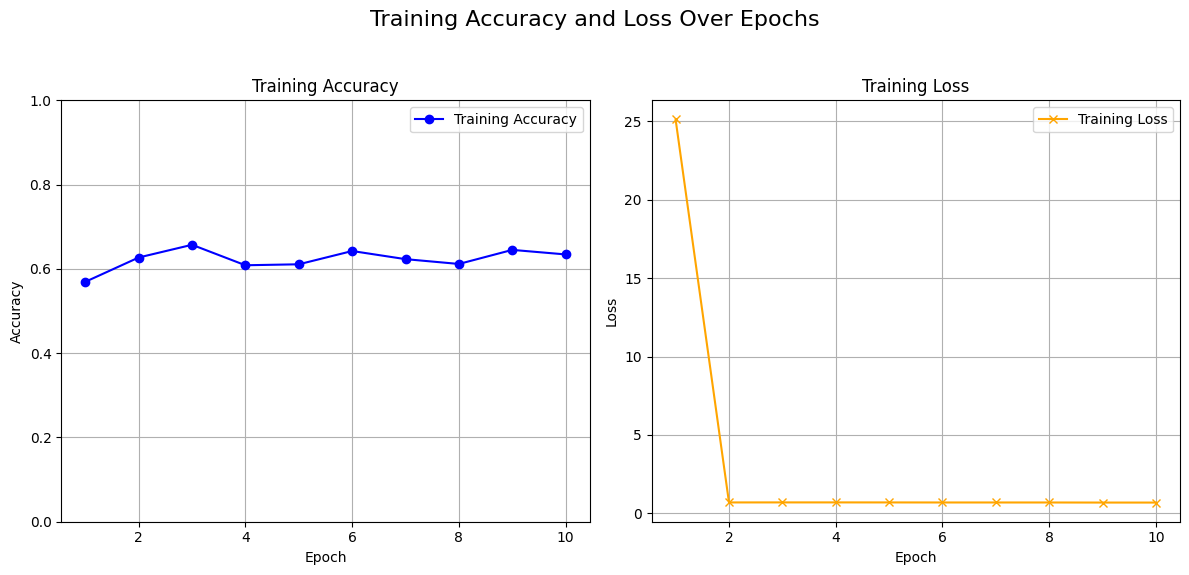

In [ ]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))  # Assuming 10 epochs

# Training accuracy values from the log
accuracy = [0.5693, 0.6270, 0.6572, 0.6086, 0.6109, 0.6424, 0.6231, 0.6117, 0.6451, 0.6343]

# Training loss values from the log
loss = [25.1264, 0.6869, 0.6889, 0.6889, 0.6876, 0.6843, 0.6842, 0.6838, 0.6791, 0.6786]

# Create a figure for the subplots
plt.figure(figsize=(12, 6))  # Adjusting figure size to be more square

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, marker='o', color='blue', label='Training Accuracy')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])  # Set y-axis limits for accuracy
plt.grid()
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='x', color='orange', label='Training Loss')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

# Add a main title for the entire figure
plt.suptitle('Training Accuracy and Loss Over Epochs', fontsize=16)

# Adjust layout to make it look nicer
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for main title

# Show the plots
plt.show()


In [ ]:
import cv2
import numpy as np

# Set the image size to match your model
image_height, image_width = 224, 224

# Define file paths (assuming images are already uploaded to '/content')
input_image_path = '/content/6 (1).png'  # Replace with your test image file
input_gaze_map_path = '/content/6.png'  # Replace with the corresponding gaze map file

# Load the uploaded image and gaze map
input_image = cv2.imread(input_image_path)  # RGB image
input_gaze_map = cv2.imread(input_gaze_map_path, cv2.IMREAD_GRAYSCALE)  # Grayscale gaze map

# Resize the image and gaze map to match the training input size (224x224 in this case)
input_image_resized = cv2.resize(input_image, (image_height, image_width)) / 255.0  # Normalize the image
input_gaze_map_resized = cv2.resize(input_gaze_map, (image_height, image_width)) / 255.0  # Normalize gaze map

# Expand dimensions to match the input shape of the model
input_image_resized = np.expand_dims(input_image_resized, axis=0)  # Add batch dimension
input_gaze_map_resized = np.expand_dims(input_gaze_map_resized, axis=0)  # Add batch dimension
input_gaze_map_resized = np.expand_dims(input_gaze_map_resized, axis=-1)  # Add channel dimension for grayscale

# Model prediction
prediction = model.predict([input_image_resized, input_gaze_map_resized])

# Get the predicted class (ASD or Typical) and confidence
predicted_class = np.argmax(prediction, axis=1)[0]  # 0 for Typical, 1 for ASD
confidence = prediction[0][predicted_class] * 100  # Convert to percentage

# Output the results
if predicted_class == 1:
    print(f"Prediction: ASD with {confidence:.2f}% confidence.")
else:
    print(f"Prediction: Typical with {confidence:.2f}% confidence.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
Prediction: ASD with 53.32% confidence.


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 463s 31s/step - accuracy: 0.4718 - loss: 3.5697 - val_accuracy: 0.0000e+00 - val_loss: 1.0762
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 498s 31s/step - accuracy: 0.6141 - loss: 0.6731 - val_accuracy: 0.0000e+00 - val_loss: 1.1037
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 504s 31s/step - accuracy: 0.6095 - loss: 0.6521 - val_accuracy: 0.0000e+00 - val_loss: 1.0646
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 461s 31s/step - accuracy: 0.6253 - loss: 0.5979 - val_accuracy: 0.0000e+00 - val_loss: 1.0369
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 500s 31s/step - accuracy: 0.6164 - loss: 0.5795 - val_accuracy: 0.0000e+00 - val_loss: 1.0312
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 457s 31s/step - accuracy: 0.6527 - loss: 0.5288 - val_accuracy: 0.5210 - val_loss: 0.9465
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 514s 35s/step - accuracy: 0.7356 - loss: 0.5511 - val_accuracy: 0.1597 - val_loss: 1.4927
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━

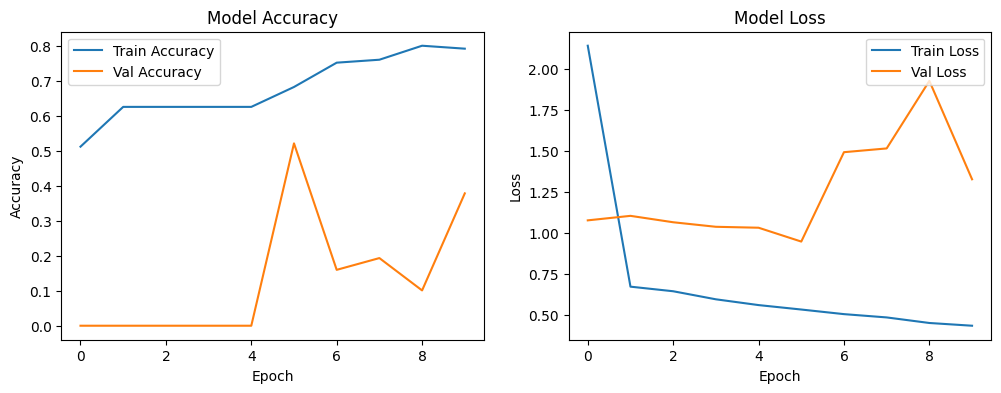

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt

# Build VGG19-based model for classification
def build_vgg19_model(input_shape):
    # Image input (VGG19 will handle this input)
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the pre-trained layers

    # Gaze map input
    gaze_input = Input(shape=(input_shape[0], input_shape[1], 1))  # Grayscale gaze map input

    # Image branch (using VGG19)
    x_image = base_model.output
    x_image = Flatten()(x_image)

    # Gaze map branch (basic CNN)
    x_gaze = Conv2D(32, (3, 3), activation='relu', padding='same')(gaze_input)
    x_gaze = MaxPooling2D(pool_size=(2, 2))(x_gaze)
    x_gaze = Conv2D(64, (3, 3), activation='relu', padding='same')(x_gaze)
    x_gaze = MaxPooling2D(pool_size=(2, 2))(x_gaze)
    x_gaze = Flatten()(x_gaze)

    # Combine both branches
    combined = Concatenate()([x_image, x_gaze])

    # Dense layers for classification
    x = Dense(128, activation='relu')(combined)
    output = Dense(2, activation='softmax')(x)  # 2 classes: ASD or Typical

    # Define the model
    model = Model(inputs=[base_model.input, gaze_input], outputs=output)

    return model

# Input shapes
image_height, image_width = 224, 224
input_shape = (image_height, image_width, 3)  # For the image

# Build VGG19 model
model = build_vgg19_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X_images, X_gaze], y, epochs=10, batch_size=32, validation_split=0.2)

# Plot accuracy and loss graphs
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.show()

# Call the plotting function
plot_training_history(history)

In [ ]:
import cv2
import numpy as np

# Set the image size to match your model
image_height, image_width = 224, 224

# Define file paths (assuming images are already uploaded to '/content')
input_image_path = '/content/11 (1).png'  # Replace with your test image file
input_gaze_map_path = '/content/11.png'  # Replace with the corresponding gaze map file

# Load the uploaded image and gaze map
input_image = cv2.imread(input_image_path)  # RGB image
input_gaze_map = cv2.imread(input_gaze_map_path, cv2.IMREAD_GRAYSCALE)  # Grayscale gaze map

# Resize the image and gaze map to match the training input size (224x224 in this case)
input_image_resized = cv2.resize(input_image, (image_height, image_width)) / 255.0  # Normalize the image
input_gaze_map_resized = cv2.resize(input_gaze_map, (image_height, image_width)) / 255.0  # Normalize gaze map

# Expand dimensions to match the input shape of the model
input_image_resized = np.expand_dims(input_image_resized, axis=0)  # Add batch dimension
input_gaze_map_resized = np.expand_dims(input_gaze_map_resized, axis=0)  # Add batch dimension
input_gaze_map_resized = np.expand_dims(input_gaze_map_resized, axis=-1)  # Add channel dimension for grayscale

# Model prediction
prediction = model.predict([input_image_resized, input_gaze_map_resized])

# Get the predicted class (ASD or Typical) and confidence
predicted_class = np.argmax(prediction, axis=1)[0]  # 0 for Typical, 1 for ASD
confidence = prediction[0][predicted_class] * 100  # Convert to percentage

# Output the results
if predicted_class == 1:
    print(f"Prediction: ASD with {confidence:.2f}% confidence.")
else:
    print(f"Prediction: Typical with {confidence:.2f}% confidence.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Prediction: Typical with 51.61% confidence.


In [ ]:
import os
import random
import cv2
import numpy as np
import pandas as pd

# Define the folder paths
asd_folder = '/content/drive/MyDrive/Autism Dataset/ASD'
control_folder = '/content/drive/MyDrive/Autism Dataset/Control'
image_folder = '/content/drive/MyDrive/Autism Dataset/Image'

# Set the image size to match your model
image_height, image_width = 224, 224

# Initialize a list to store the results
results = []

# Function to randomly pick a gaze image and its corresponding image
def random_sample_and_predict():
    # Randomly choose whether to take from ASD or Control
    if random.choice(['ASD', 'Control']) == 'ASD':
        folder = asd_folder
        true_label = 1  # ASD
    else:
        folder = control_folder
        true_label = 0  # Control

    # Randomly select a file from the chosen folder
    file_name = random.choice(os.listdir(folder))
    gaze_map_path = os.path.join(folder, file_name)
    image_path = os.path.join(image_folder, file_name)

    # Load the uploaded image and gaze map
    input_image = cv2.imread(image_path)  # RGB image
    input_gaze_map = cv2.imread(gaze_map_path, cv2.IMREAD_GRAYSCALE)  # Grayscale gaze map

    # Resize the image and gaze map to match the training input size
    input_image_resized = cv2.resize(input_image, (image_height, image_width)) / 255.0  # Normalize the image
    input_gaze_map_resized = cv2.resize(input_gaze_map, (image_height, image_width)) / 255.0  # Normalize gaze map

    # Expand dimensions to match the input shape of the model
    input_image_resized = np.expand_dims(input_image_resized, axis=0)  # Add batch dimension
    input_gaze_map_resized = np.expand_dims(input_gaze_map_resized, axis=0)  # Add batch dimension
    input_gaze_map_resized = np.expand_dims(input_gaze_map_resized, axis=-1)  # Add channel dimension for grayscale

    # Model prediction
    prediction = model.predict([input_image_resized, input_gaze_map_resized])

    # Get the predicted class (0 for Typical, 1 for ASD) and confidence
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = prediction[0][predicted_class] * 100  # Convert to percentage

    # Determine if the prediction is correct
    correct = (predicted_class == true_label)

    # Store the result
    results.append({
        'File Name': file_name,
        'True Label': 'ASD' if true_label == 1 else 'Control',
        'Predicted Label': 'ASD' if predicted_class == 1 else 'Control',
        'Correct': correct,
        'Confidence': f"{confidence:.2f}%"
    })

# Run the sampling and prediction 10 times
for _ in range(20):
    random_sample_and_predict()

# Create a DataFrame to display results
results_df = pd.DataFrame(results)
print(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
   File Name True Label Predicted Label  Correct Confidence
0    151.png    Control         Control     True     51.61%
1     99.png    Control             ASD    False     61.20%
2    291.png        ASD             ASD     True    